In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.1 MB/s eta 0:00:00


In [ ]:
from google.colab import files
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import tensorflow as tf
import numpy as np
from transformers import *
from tqdm import tqdm
import os
import tqdm
import io
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import warnings
import torch
from gensim.utils import simple_preprocess
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  warnings.warn(
Xformers is not installed correctly. If you want to use memorry_efficient_attenti

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
EPOCHS = 6
N_SPLITS = 5

<Axes: xlabel='Emotion', ylabel='count'>

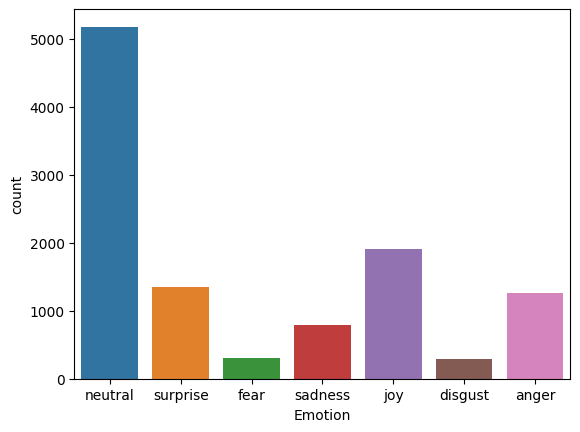

In [ ]:
#uploads = files.upload()
#uploads = files.upload()
#uploads = files.upload()
#uploads = files.upload()
#uploads = files.upload()
#uploads = files.upload()
def get_meld_data(path):
  df = pd.read_csv(path)
  df.columns = ['No.','Sentence','Speaker','Emotion','Sentiment','Dialogue_ID','Utterance_ID','Season','Episode','StartTime','Endtime']
  df.drop(columns = ['No.','Speaker','Sentiment','Dialogue_ID','Utterance_ID','Season','Episode','StartTime','Endtime'], inplace=True)
  return df
meld_test_df = get_meld_data('test_sent_emo.csv')
meld_train_df = get_meld_data('train_sent_emo.csv')
meld_valid_df = get_meld_data('dev_sent_emo.csv')

#Merge train and validation set
meld_train_df = pd.concat([meld_train_df, meld_valid_df], ignore_index=True) #Add caption to graph for clarification, what it means and insight
sns.countplot(x='Emotion', data=meld_train_df)

In [ ]:
meld_train_df.Emotion.value_counts()

In [ ]:
meld_test_df.info(), meld_train_df.info()

In [ ]:
meld_train_df.sample(10)

,Sentence,Emotion
10761,"Your Mom, your telling me, your telling me, ab...",disgust
10073,Well that’s true.,neutral
6953,"Yes, I suppose I am a dog. But Issac, see I-I ...",neutral
7100,"We’re really gonna do this, huh?",surprise
296,Now couldn't you just have made some sort of i...,anger
7127,I don’t have too. I can just look at you.,joy
761,"I mean, I think it would’ve happened either way.",neutral
10673,I'm okay. I gotta go down to the police statio...,sadness
6117,It,neutral
8080,Oh okay. But y’know what? Be careful. Because ...,neutral


In [ ]:
#Undersampling the majority emotion, which is neutral for a more balanced dataset
#sampl_dict = {'neutral':2000}
#rus = RandomUnderSampler(random_state=11, sampling_strategy=sampl_dict)

#use k-fold cross validation

#meld_train_df, meld_train_df.Emotion[''] = rus.fit_resample(meld_train_df,meld_train_df.Emotion)
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=meld_train_df, y=meld_train_df.Emotion)):
    meld_train_df.loc[val_, "kfold"] = fold

In [ ]:
meld_train_df.sample(10)

,Sentence,Emotion,kfold
1770,Irony?,surprise,0.0
2023,You do?,surprise,4.0
918,I bet this will work!,joy,0.0
492,"Me? Oh, no, I am not an actress.",disgust,3.0
1163,I love ya!,joy,4.0
34,He took my snack!,anger,0.0
1141,"Oh, really, really, really?",joy,4.0
1194,When I was six years old.,neutral,0.0
62,God!,anger,1.0
398,"Oh, God, he's such a pig,",disgust,1.0


In [ ]:
meld_train_df.Emotion.value_counts()

neutral     5180
joy         1906
surprise    1355
anger       1262
sadness      794
fear         308
disgust      293
Name: Emotion, dtype: int64

<Axes: xlabel='Emotion', ylabel='count'>

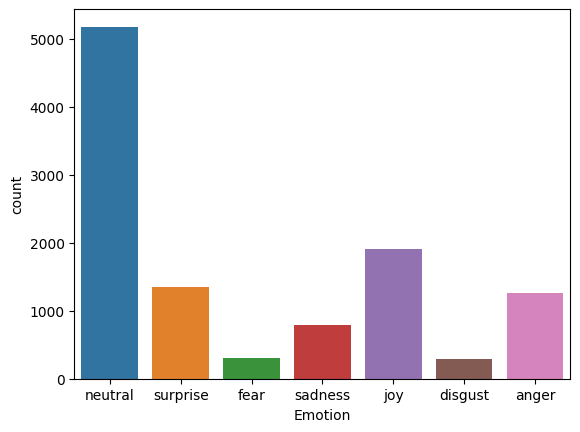

In [ ]:
sns.countplot(x='Emotion', data=meld_train_df) #caption needed here

In [ ]:
def get_data(path):
    df = pd.read_excel(path, sheet_name=None)['Sheet1']
    df.columns = ['index', 'Emotion', 'Sentence']
    # unused column
    df.drop(columns=['index'], inplace=True)
    return df

vsmec_train_df = get_data('train_nor_811.xlsx')
vsmec_test_df = get_data('test_nor_811.xlsx')
vsmec_valid_df = get_data('valid_nor_811.xlsx')

vsmec_train_df = pd.concat([vsmec_train_df, vsmec_valid_df], ignore_index=True)
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=vsmec_train_df, y=vsmec_train_df.Emotion)):
    vsmec_train_df.loc[val_, "kfold"] = fold

In [ ]:
vsmec_train_df.info(), vsmec_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Emotion   6234 non-null   object 
 1   Sentence  6234 non-null   object 
 2   kfold     6234 non-null   float64
dtypes: float64(1), object(2)
memory usage: 146.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotion   693 non-null    object
 1   Sentence  693 non-null    object
dtypes: object(2)
memory usage: 11.0+ KB


(None, None)

In [ ]:
vsmec_train_df.sample(10)

,Emotion,Sentence,kfold
303,Other,may quá tao đang nhà đắp chăn xem cảnh này chứ...,0.0
3654,Fear,thế giới này thật đáng sợ ai chả đĩa bay cho t...,2.0
770,Enjoyment,đợi nốt ván đã =)))))))),0.0
1288,Sadness,nắng cũng đã sắp tàn sao mà chả thấy em đâu ...,1.0
4050,Other,"bằng lòng với những gì mình đang có đi , trên ...",3.0
5773,Anger,láo vãi,4.0
469,Other,mới ra mà nắm bắt nhanh thế,0.0
4118,Enjoyment,dăm ba con nhện nghĩ tao sợ (((=,3.0
306,Fear,per ê tao với mày mà đi cái cầu này chắc rớt n...,0.0
5104,Disgust,không ngon như lần trước nữa,4.0


<Axes: xlabel='Emotion', ylabel='count'>

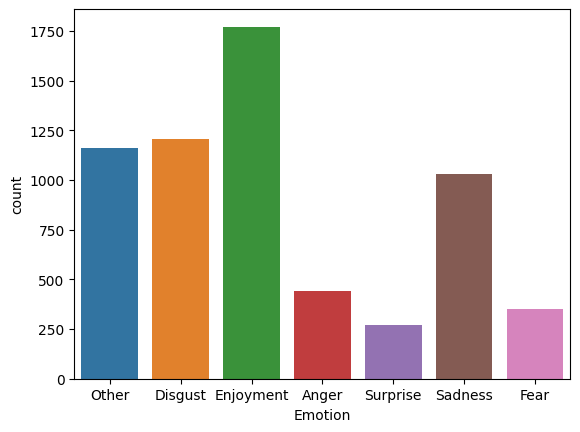

In [ ]:
sns.countplot(x='Emotion', data=vsmec_train_df)

In [ ]:
VNtokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Could not locate the tokenizer configuration file, will try to use the model config instead.


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--vinai--phobert-base/snapshots/a47f76f1ac0b6b89f82d15dbe9829935a0014c38/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/phobert-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 258,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "PhobertTokenizer",
  "transformers_version": "4.29.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}



loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--vinai--phobert-base/snapshots/a47f76f1ac0b6b89f82d15dbe9829935a0014c38/vocab.txt
loading file bpe.codes from cache at /root/.cache/huggingface/hub/models--vinai--phobert-base/snapshots/a47f76f1ac0b6b89f82d15dbe9829935a0014c38/bpe.codes
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--vinai--phobert-base/snapshots/a47f76f1ac0b6b89f82d15dbe9829935a0014c38/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/phobert-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return 
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self,text):
        if text.lower()=='enjoyment' or text.lower()=="joy":
            return 0
        elif text.lower()=='disgust':
            return 1
        elif text.lower()=='sadness':
            return 2
        elif text.lower()=='anger':
            return 3
        elif text.lower()=='surprise':
            return 4
        elif text.lower()=='fear':
            return 5
        else:
            return 6

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['Sentence']
        text = ' '.join(simple_preprocess(text))
        label = self.labelencoder(row['Emotion'])

        return text, label

In [ ]:
class VNSentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(VNSentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

In [ ]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(model,test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())
    
    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)

In [ ]:
def prepare_loaders(df, fold, tokenizer):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = SentimentDataset(df_train, tokenizer, max_len=120)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=120)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)
    
    return train_loader, valid_loader

In [ ]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(vsmec_train_df, fold=fold,tokenizer=VNtokenizer)
    model = VNSentimentClassifier(n_classes=7).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer, 
                num_warmup_steps=0, 
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval(model)

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            best_acc = val_acc

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--vinai--phobert-base/snapshots/a47f76f1ac0b6b89f82d15dbe9829935a0014c38/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/phobert-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 258,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "PhobertTokenizer",
  "transformers_version": "4.29.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}



-----------Fold: 1 ------------------


loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--vinai--phobert-base/snapshots/a47f76f1ac0b6b89f82d15dbe9829935a0014c38/pytorch_model.bin
Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of RobertaModel were initialized from the model checkpoint at vinai/phob

Epoch 1/6
------------------------------
Train Accuracy: 0.38480048125125327 Loss: 1.6305945637898567
Valid Accuracy: 0.5084202085004009 Loss: 1.3305147993258941
Epoch 2/6
------------------------------
Train Accuracy: 0.5678764788449969 Loss: 1.2293228757305024
Valid Accuracy: 0.5733761026463512 Loss: 1.2162753030275688
Epoch 3/6
------------------------------
Train Accuracy: 0.6697413274513736 Loss: 0.9805871862440537
Valid Accuracy: 0.6046511627906976 Loss: 1.1304890574553075
Epoch 4/6
------------------------------
Train Accuracy: 0.7300982554642069 Loss: 0.8042800126549525
Valid Accuracy: 0.5942261427425822 Loss: 1.1676065287528894
Epoch 5/6
------------------------------
Train Accuracy: 0.7796270302787247 Loss: 0.6771893358001342
Valid Accuracy: 0.6118684843624699 Loss: 1.206786300127323
Epoch 6/6
------------------------------
Train Accuracy: 0.8143172247844396 Loss: 0.5911626610904932
Valid Accuracy: 0.6206896551724138 Loss: 1.1937103871351633


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--vinai--phobert-base/snapshots/a47f76f1ac0b6b89f82d15dbe9829935a0014c38/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/phobert-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 258,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "PhobertTokenizer",
  "transformers_version": "4.29.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

loading weights file pytorch_model.bin from cache at /root/.cache/hugging

-----------Fold: 2 ------------------


Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of RobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaModel for predictions without further training.


Epoch 1/6
------------------------------
Train Accuracy: 0.39743332664928815 Loss: 1.593483832784188
Valid Accuracy: 0.5196471531676022 Loss: 1.3529336758148975
Epoch 2/6
------------------------------
Train Accuracy: 0.5522358131140966 Loss: 1.257562167942524
Valid Accuracy: 0.5805934242181234 Loss: 1.2195727618841024
Epoch 3/6
------------------------------
Train Accuracy: 0.6482855424102667 Loss: 1.027438246191312
Valid Accuracy: 0.5813953488372093 Loss: 1.1846838769240258
Epoch 4/6
------------------------------
Train Accuracy: 0.702025265690796 Loss: 0.8809783042241366
Valid Accuracy: 0.6126704089815558 Loss: 1.1887233780744748
Epoch 5/6
------------------------------
Train Accuracy: 0.7573691598155203 Loss: 0.7377257563937933
Valid Accuracy: 0.6014434643143545 Loss: 1.2098632833132377
Epoch 6/6
------------------------------
Train Accuracy: 0.788650491277321 Loss: 0.6526324798663458


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--vinai--phobert-base/snapshots/a47f76f1ac0b6b89f82d15dbe9829935a0014c38/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/phobert-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 258,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "PhobertTokenizer",
  "transformers_version": "4.29.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

loading weights file pytorch_model.bin from cache at /root/.cache/hugging

Valid Accuracy: 0.6014434643143545 Loss: 1.1978871142252898
-----------Fold: 3 ------------------


Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of RobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaModel for predictions without further training.


Epoch 1/6
------------------------------
Train Accuracy: 0.3938239422498496 Loss: 1.5838732291490605
Valid Accuracy: 0.5020048115477145 Loss: 1.341709276040395
Epoch 2/6
------------------------------
Train Accuracy: 0.5682775215560457 Loss: 1.1980501522238438
Valid Accuracy: 0.5838011226944667 Loss: 1.1711387848242736
Epoch 3/6
------------------------------
Train Accuracy: 0.6759574894726288 Loss: 0.954580183308094
Valid Accuracy: 0.5862068965517241 Loss: 1.1611747222068982
Epoch 4/6
------------------------------
Train Accuracy: 0.7449368357730098 Loss: 0.7675776277215053
Valid Accuracy: 0.5934242181234963 Loss: 1.1611959422246003
Epoch 5/6
------------------------------
Train Accuracy: 0.7880489272107479 Loss: 0.6469008944068964
Valid Accuracy: 0.591018444266239 Loss: 1.225886079745415
Epoch 6/6
------------------------------
Train Accuracy: 0.8291558050932424 Loss: 0.5579693551915579
Valid Accuracy: 0.6014434643143545 Loss: 1.2060779975010798


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--vinai--phobert-base/snapshots/a47f76f1ac0b6b89f82d15dbe9829935a0014c38/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/phobert-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 258,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "PhobertTokenizer",
  "transformers_version": "4.29.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

loading weights file pytorch_model.bin from cache at /root/.cache/hugging

-----------Fold: 4 ------------------


Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of RobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaModel for predictions without further training.


Epoch 1/6
------------------------------
Train Accuracy: 0.291959093643473 Loss: 1.7728129854569068
Valid Accuracy: 0.48195669607056935 Loss: 1.516141217488509
Epoch 2/6
------------------------------
Train Accuracy: 0.48646480850210544 Loss: 1.4086316185883987
Valid Accuracy: 0.5765838011226945 Loss: 1.2200806454206123
Epoch 3/6
------------------------------
Train Accuracy: 0.6186083817926609 Loss: 1.099974845082332
Valid Accuracy: 0.6014434643143545 Loss: 1.1379504524744475
Epoch 4/6
------------------------------
Train Accuracy: 0.6934028474032484 Loss: 0.9037989920530564
Valid Accuracy: 0.6214915797914996 Loss: 1.1264715699049144
Epoch 5/6
------------------------------
Train Accuracy: 0.7515540405053138 Loss: 0.7527218498289585
Valid Accuracy: 0.6134723336006416 Loss: 1.1491187772689722
Epoch 6/6
------------------------------
Train Accuracy: 0.7876478844996992 Loss: 0.6611644389728705
Valid Accuracy: 0.6142742582197274 Loss: 1.1639784677670553
-----------Fold: 5 ----------------

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--vinai--phobert-base/snapshots/a47f76f1ac0b6b89f82d15dbe9829935a0014c38/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/phobert-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 258,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "PhobertTokenizer",
  "transformers_version": "4.29.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

loading weights file pytorch_model.bin from cache at /root/.cache/hugging

Epoch 1/6
------------------------------
Train Accuracy: 0.33079390537289494 Loss: 1.7267119189103444
Valid Accuracy: 0.47351524879614765 Loss: 1.445702164601057
Epoch 2/6
------------------------------
Train Accuracy: 0.5260625501202887 Loss: 1.319570469359557
Valid Accuracy: 0.5425361155698234 Loss: 1.2733832872830904
Epoch 3/6
------------------------------
Train Accuracy: 0.6371291098636728 Loss: 1.0515927689579816
Valid Accuracy: 0.5834670947030498 Loss: 1.1919775719826038
Epoch 4/6
------------------------------
Train Accuracy: 0.71271050521251 Loss: 0.8568350199896556
Valid Accuracy: 0.5882825040128411 Loss: 1.1948302793197143
Epoch 5/6
------------------------------
Train Accuracy: 0.7566158781074579 Loss: 0.7322044783295729
Valid Accuracy: 0.5874799357945425 Loss: 1.2050457314038887
Epoch 6/6
------------------------------
Train Accuracy: 0.7947072975140337 Loss: 0.6413159510359551
Valid Accuracy: 0.6043338683788122 Loss: 1.2286604810983708


In [ ]:
def VNtest(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = VNSentimentClassifier(n_classes=7)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)
        
        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)
    
    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [ ]:
test_dataset = SentimentDataset(vsmec_test_df, VNtokenizer, max_len=120)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = VNtest(test_loader)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--vinai--phobert-base/snapshots/a47f76f1ac0b6b89f82d15dbe9829935a0014c38/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/phobert-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 258,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "PhobertTokenizer",
  "transformers_version": "4.29.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

loading weights file pytorch_model.bin from cache at /root/.cache/hugging

              precision    recall  f1-score   support

           0       0.68      0.67      0.67       193
           1       0.58      0.61      0.60       132
           2       0.62      0.65      0.63       116
           3       0.45      0.38      0.41        40
           4       0.61      0.30      0.40        37
           5       0.65      0.67      0.66        46
           6       0.50      0.55      0.52       129

    accuracy                           0.60       693
   macro avg       0.58      0.55      0.56       693
weighted avg       0.60      0.60      0.59       693



<Axes: >

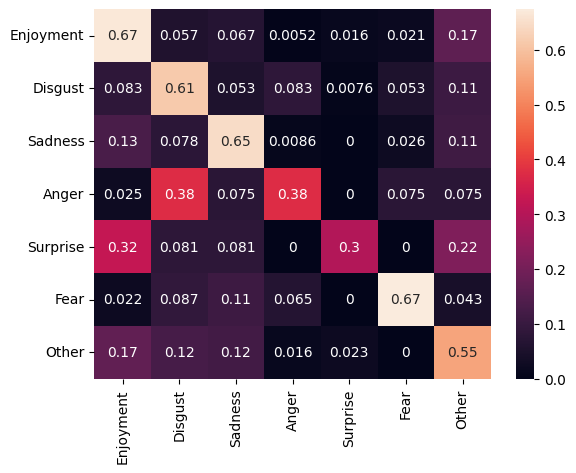

In [ ]:
class_names = ['Enjoyment', 'Disgust', 'Sadness', 'Anger', 'Surprise', 'Fear', 'Other']
sns.heatmap(confusion_matrix(real_values, predicts, normalize='true'), annot=True, xticklabels = class_names, yticklabels = class_names)

In [ ]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

for i in range(15):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(vsmec_test_df.iloc[wrong_arr[i]].Sentence)
    print(f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real_values[wrong_arr[i]]]})')

In [ ]:
def infer(text,model, tokenizer, max_len=120):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Text: {text}')
    print(f'Sentiment: {class_names[y_pred]}')

In [ ]:
infer('Tôi rất vui khi được gặp bạn',model, VNtokenizer)

NameError: ignored

In [ ]:
ENtokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_ac

In [ ]:
class ENSentimentClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, n_classes, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(ENSentimentClassifier, self).__init__()

        # Instantiate BERT model
        self.bert = AutoModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

In [ ]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(meld_train_df, fold=fold,tokenizer=ENtokenizer)
    ENmodel = ENSentimentClassifier(n_classes=7,freeze_bert=False).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(ENmodel.parameters(), lr=2e-5)
    
    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer, 
                num_warmup_steps=0, 
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(ENmodel, criterion, optimizer, train_loader)
        val_acc = eval(ENmodel)

        if val_acc > best_acc:
            torch.save(ENmodel.state_dict(), f'bert_fold{fold+1}.pth')
            best_acc = val_acc

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



-----------Fold: 1 ------------------


loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceC

Epoch 1/6
------------------------------
Train Accuracy: 0.49515656679432307 Loss: 1.46494771564329
Valid Accuracy: 0.536036036036036 Loss: 1.3027229137557874
Epoch 2/6
------------------------------
Train Accuracy: 0.5910114890741158 Loss: 1.199812729562725
Valid Accuracy: 0.5481981981981983 Loss: 1.2696276217055835
Epoch 3/6
------------------------------
Train Accuracy: 0.6716602838477135 Loss: 0.9866782353268013
Valid Accuracy: 0.5396396396396397 Loss: 1.3796165915701886
Epoch 4/6
------------------------------
Train Accuracy: 0.740144176616355 Loss: 0.7881034966524657
Valid Accuracy: 0.5355855855855856 Loss: 1.4927559001840276
Epoch 5/6
------------------------------
Train Accuracy: 0.7882405947285425 Loss: 0.6424099511928386
Valid Accuracy: 0.5288288288288289 Loss: 1.5971232914238525
Epoch 6/6
------------------------------
Train Accuracy: 0.8204550574453706 Loss: 0.5527261014188732


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_m

Valid Accuracy: 0.5270270270270271 Loss: 1.6303370474911423
-----------Fold: 2 ------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of BertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoi

Epoch 1/6
------------------------------
Train Accuracy: 0.5099121423744086 Loss: 1.4172490503336932
Valid Accuracy: 0.5391891891891892 Loss: 1.3082177330264084
Epoch 2/6
------------------------------
Train Accuracy: 0.610497859878351 Loss: 1.1364870649200303
Valid Accuracy: 0.5432432432432432 Loss: 1.322308972156305
Epoch 3/6
------------------------------
Train Accuracy: 0.7010587970263573 Loss: 0.8957951082839622
Valid Accuracy: 0.5247747747747747 Loss: 1.419789073064173
Epoch 4/6
------------------------------
Train Accuracy: 0.7791169182248254 Loss: 0.6911958011152508
Valid Accuracy: 0.5162162162162163 Loss: 1.5685951735475938
Epoch 5/6
------------------------------
Train Accuracy: 0.8267627844109033 Loss: 0.5454731126626332
Valid Accuracy: 0.4936936936936937 Loss: 1.7174922000589987
Epoch 6/6
------------------------------
Train Accuracy: 0.8599909889614779 Loss: 0.4599624148897223


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_m

Valid Accuracy: 0.5013513513513513 Loss: 1.769577789649689
-----------Fold: 3 ------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of BertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoi

Epoch 1/6
------------------------------
Train Accuracy: 0.5041676053165127 Loss: 1.4194496238553846
Valid Accuracy: 0.554954954954955 Loss: 1.2792038308630744
Epoch 2/6
------------------------------
Train Accuracy: 0.5840279342194188 Loss: 1.1916096718461664
Valid Accuracy: 0.5545045045045045 Loss: 1.283321523837906
Epoch 3/6
------------------------------
Train Accuracy: 0.6735751295336787 Loss: 0.9717393379490655
Valid Accuracy: 0.5545045045045045 Loss: 1.3173362749943631
Epoch 4/6
------------------------------
Train Accuracy: 0.7496057670646542 Loss: 0.7572626356606011
Valid Accuracy: 0.5518018018018018 Loss: 1.4467231189604286
Epoch 5/6
------------------------------
Train Accuracy: 0.805699481865285 Loss: 0.6060348990264239
Valid Accuracy: 0.5391891891891892 Loss: 1.5511831173793875
Epoch 6/6
------------------------------
Train Accuracy: 0.8403919801757153 Loss: 0.5095071514581775


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_m

Valid Accuracy: 0.5364864864864864 Loss: 1.6117351055145264
-----------Fold: 4 ------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of BertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoi

Epoch 1/6
------------------------------
Train Accuracy: 0.49205991665728127 Loss: 1.4487723808030823
Valid Accuracy: 0.566020730058585 Loss: 1.2701726024099391
Epoch 2/6
------------------------------
Train Accuracy: 0.6016443293163645 Loss: 1.1620912426226848
Valid Accuracy: 0.5637674628210906 Loss: 1.2556432978712397
Epoch 3/6
------------------------------
Train Accuracy: 0.6856627998648497 Loss: 0.940567687234363
Valid Accuracy: 0.5123929698062191 Loss: 1.4270459546459664
Epoch 4/6
------------------------------
Train Accuracy: 0.7612343732402298 Loss: 0.7319622865399799
Valid Accuracy: 0.5326723749436684 Loss: 1.4912421501797737
Epoch 5/6
------------------------------
Train Accuracy: 0.809325374479108 Loss: 0.5865710359033164
Valid Accuracy: 0.519603424966201 Loss: 1.643348024474631
Epoch 6/6
------------------------------
Train Accuracy: 0.8413109584412659 Loss: 0.5005765969420338


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_m

Valid Accuracy: 0.5132942767012167 Loss: 1.6917730368298591
-----------Fold: 5 ------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of BertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoi

Epoch 1/6
------------------------------
Train Accuracy: 0.5064759544993805 Loss: 1.4263768464595348
Valid Accuracy: 0.5538530869761153 Loss: 1.2822764906094228
Epoch 2/6
------------------------------
Train Accuracy: 0.6016443293163645 Loss: 1.1595015627843839
Valid Accuracy: 0.5574583145561064 Loss: 1.276800126909352
Epoch 3/6
------------------------------
Train Accuracy: 0.6938844464466719 Loss: 0.9319840099360491
Valid Accuracy: 0.5452906714736367 Loss: 1.3538793231085908
Epoch 4/6
------------------------------
Train Accuracy: 0.7681045162743553 Loss: 0.7195708729930826
Valid Accuracy: 0.5425867507886435 Loss: 1.4777036223480169
Epoch 5/6
------------------------------
Train Accuracy: 0.8142808874873296 Loss: 0.5782723256059595
Valid Accuracy: 0.5398828301036503 Loss: 1.5828850963990466
Epoch 6/6
------------------------------
Train Accuracy: 0.8442392161279424 Loss: 0.48849902073810764
Valid Accuracy: 0.5367282559711581 Loss: 1.6495200447041354


In [ ]:
def ENtest(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = ENSentimentClassifier(n_classes=7)
        model.to(device)
        model.load_state_dict(torch.load(f'bert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    ENpredicts = []
    predict_probs = []
    ENreal_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)
        
        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        ENpredicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        ENreal_values.extend(targets)
    
    ENpredicts = torch.stack(ENpredicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    ENreal_values = torch.stack(ENreal_values).cpu()
    print(classification_report(ENreal_values, ENpredicts))
    return ENreal_values, ENpredicts

In [ ]:
test_dataset = SentimentDataset(meld_test_df, ENtokenizer, max_len=120)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
ENreal_values, ENpredicts = ENtest(test_loader)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_m

              precision    recall  f1-score   support

           0       0.53      0.33      0.40       402
           1       0.00      0.00      0.00        68
           2       0.41      0.18      0.25       208
           3       0.39      0.23      0.29       345
           4       0.54      0.50      0.52       281
           5       0.00      0.00      0.00        50
           6       0.60      0.86      0.71      1256

    accuracy                           0.56      2610
   macro avg       0.35      0.30      0.31      2610
weighted avg       0.51      0.56      0.52      2610



<Axes: >

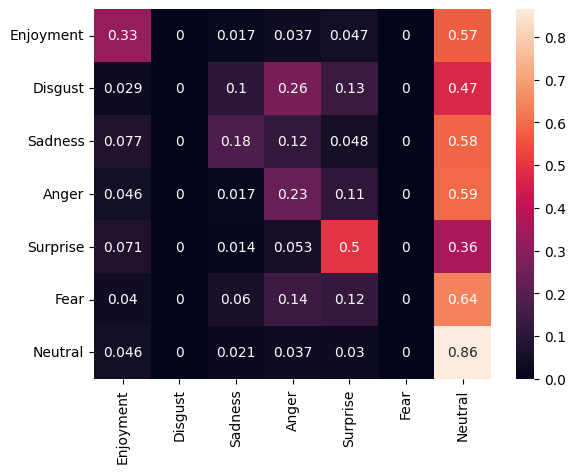

In [ ]:
class_names = ['Enjoyment', 'Disgust', 'Sadness', 'Anger', 'Surprise', 'Fear', 'Neutral']
sns.heatmap(confusion_matrix(real_values, predicts, normalize='true'), annot=True, xticklabels = class_names, yticklabels = class_names) #caption needed. Write it all down!

In [ ]:
infer("I'm so happy to meet you",ENmodel, ENtokenizer)

Text: I'm so happy to meet you
Sentiment: Enjoyment


TypeError: ignored